# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

### **Wait!** 
Aren't cifar100 and cifar10 mutually exclusive? 

(Yes, so we have an OOD set ready to be used. Yay!)

In [1]:
# Your code here.
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FakeData, CIFAR10, CIFAR100
import torchvision.transforms as transforms

# Select best device.
device = 'cuda' if torch.cuda.is_available() else 'cpu'


Here we define the ID dataset and Dataloader

In [2]:
# We will use CIFAR-10 as our in-distribution dataset.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the datasets and setup the DataLoaders.
batch_size = 32
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)

ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12705104.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Now we load the CIFAR100 dataset for OOD sampling

In [13]:
# CIFAR-100 DATASET LOADING
batch_size = 32
#TODO: subset different classes for CIFAR-10
dataset_ood = CIFAR100(root='./data', train=False, download=True, transform=transform)

dl_ood = torch.utils.data.DataLoader(dataset_ood, batch_size=batch_size, shuffle=True, num_workers=2)



Files already downloaded and verified


A very simple CNN

In [4]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Let's now train the model from scratch

In [5]:
# USE THIS CELL TO TRAIN MODEL FROM SCRATCH.
model = CNN().to(device)

# Train for only 50 epochs.
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Main training loop.
for epoch in range(epochs):
    running_loss = 0.0
    # Iterate over all batches.
    for (i, (Xs, ys)) in enumerate(dl_train, 0):
        Xs = Xs.to(device)
        ys = ys.to(device)
        
        # Make a gradient step.
        optimizer.zero_grad()
        outputs = model(Xs)
        loss = criterion(outputs, ys)
        loss.backward()
        optimizer.step()
        
        # Track epoch loss.
        running_loss += loss.item()

    # Print average epoch loss.
    print(f'{epoch + 1} loss: {running_loss / len(dl_train):.3f}')

print('Finished Training')
torch.save(model.state_dict(), './cifar10_CNN.pth')

1 loss: 1.623
2 loss: 1.305
3 loss: 1.176
4 loss: 1.091
5 loss: 1.022
6 loss: 0.970
7 loss: 0.920
8 loss: 0.881
9 loss: 0.845
10 loss: 0.811
11 loss: 0.776
12 loss: 0.755
13 loss: 0.729
14 loss: 0.706
15 loss: 0.687
16 loss: 0.663
17 loss: 0.646
18 loss: 0.631
19 loss: 0.611
20 loss: 0.597
21 loss: 0.585
22 loss: 0.567
23 loss: 0.551
24 loss: 0.536
25 loss: 0.533
26 loss: 0.514
27 loss: 0.505
28 loss: 0.492
29 loss: 0.485
30 loss: 0.471
31 loss: 0.460
32 loss: 0.456
33 loss: 0.444
34 loss: 0.435
35 loss: 0.428
36 loss: 0.424
37 loss: 0.409
38 loss: 0.408
39 loss: 0.399
40 loss: 0.392
41 loss: 0.387
42 loss: 0.380
43 loss: 0.368
44 loss: 0.369
45 loss: 0.356
46 loss: 0.354
47 loss: 0.352
48 loss: 0.353
49 loss: 0.333
50 loss: 0.338
Finished Training


We now test the performances using the logit to score the OOD samples

In [6]:
# Function to collect all logits from the model on entire dataset.
def collect_logits(model, dl):
    logits = []
    with torch.no_grad():
        for (Xs, _) in dl:
            logits.append(model(Xs.to(device)).cpu().numpy())
    return np.vstack(logits)

In [14]:
# Collect logits on CIFAR-10 test set (ID) and noise (very OOD).
logits_ID = collect_logits(model, dl_test)
logits_OOD = collect_logits(model, dl_ood)

And now we plot the histogram of the scores!

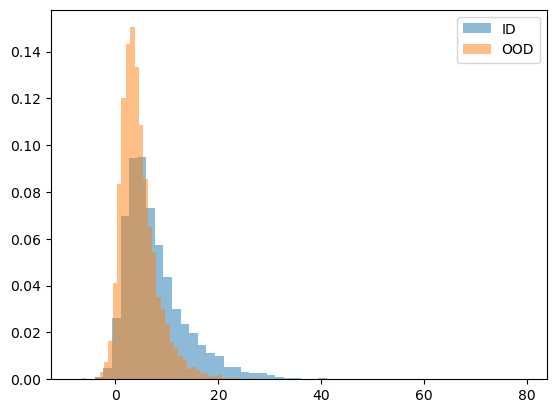

In [16]:
# Plot the *distribution* of max logit outputs.
_ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(logits_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

In [21]:
# OOD with max logit
threshold = 5
print(f'Accuracy: {(logits_ID.max(1) > threshold).mean() * 100:.2f}%') # Percentage of ID samples over 5 logit
print(f'OOD: {(logits_OOD.max(1) > threshold).mean() * 100:.2f}%') # Percentage of OOD samples over 5 logit

Accuracy: 60.43%
OOD: 35.57%


I'll use 5 as threshold for the OOD samples

In [23]:
detection = []
ground_truth = []

# Append 1 if the sample is detected as OOD, 0 otherwise
for i in logits_ID.max(1):
    if i > threshold:
        detection.append(1)
    else:  
        detection.append(0)

for i in logits_OOD.max(1):
    if i > threshold:
        detection.append(1)
    else:  
        detection.append(0)

# Now i create the ground thruth
for i in range(len(logits_ID.max(1))):
    ground_truth.append(1)

for i in range(len(logits_OOD.max(1))):
    ground_truth.append(0)

In [24]:
# Little check ìf the length is correct
print(len(detection))
print(len(ground_truth))

20000
20000


### Nice! ###

Let's now measure the performances using the AUROC metric and the AUPR metric

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


### AUROC ###

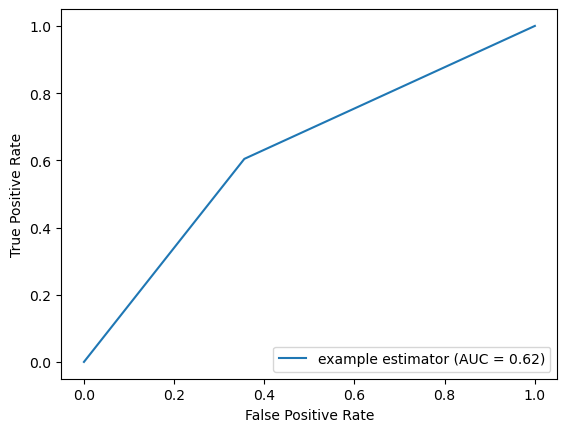

In [25]:
# Your code here.
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(ground_truth, detection)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()
plt.show()

### Precision-Recall ###

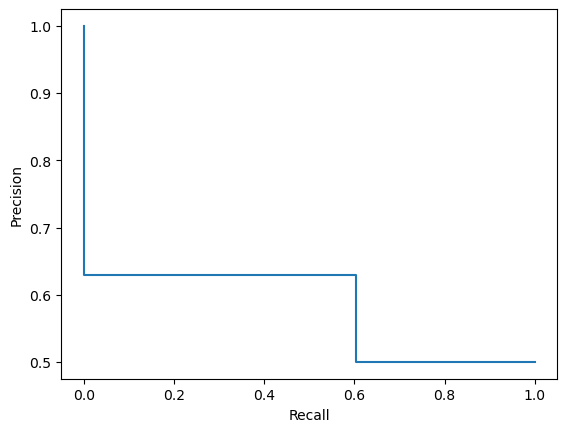

In [26]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(ground_truth, detection)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

plt.show()

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [4]:
# Your code here.

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [ ]:
# Your code here.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.
